# Project 3 Web APIs and NLP 

## Contents

1. [Introduction](#Introduction)
2. [Data Cleaning and EDA](#Data-Cleaning-and-EDA)
3. [Baseline Model](#Baseline-model)
4. [Comparison of performance of ML classification models](#Comparison-of-performance-of-ML-classification-models)
5. [Further analysis of the best gradient boosting model ](#Further-analysis-of-the-best-gradient-boosting-model)
6. [Conclusions and TODO](#Conclusions-and-TODO)

## Introduction

**About Reddit**

[Reddit](https://www.reddit.com/) is an American social news aggregation, web content rating, and discussion website. Registered members submit content to the site such as links, text posts, images, and videos, which are then voted up or down by other members. Posts are organized by subject into user-created boards called "communities" or "subreddits", which cover a variety of topics [(source)](https://en.wikipedia.org/wiki/Reddit). 

**Goals**

This analysis aims to scrape data from two subreddits and build a machine learning model to classify them. 

**The subreddits**

The subreddits being used in this analysis and their descriptions from (https://www.reddit.com/) are given below:

- [r/languagelearning](https://www.reddit.com/r/languagelearning/)

    This is a subreddit for anybody interested in the pursuit of languages. Whether you are just starting, a polyglot or a language nerd, this is the place for you!
        
        
- [r/linguistics](https://www.reddit.com/r/linguistics/)

    \*\*lin⋅guis⋅tics\*\*: the scientific study of human \*language\* \* what form does it take? \* how is meaning constructed? \* how is it structured? \* how is it produced?

**Problem Statement**

[Section 3](#Baseline-model) elaborates on a basic model with an accuracy of 74%. The aim is to build more sophisticated models and improve on this baseline accuracy

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# seaborn plot styles

sns.set_style("dark")
sns.set_palette("deep")
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
myblue = '#0b5394'

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score

import pickle

from scipy.stats import uniform

#display all output form a cell not just the last (the options are 'all', 'none', 'last' and 'last_expr'.)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import time

## Data Cleaning and EDA

Data cleaning and EDA details are available in a [separate notebook](https://git.generalassemb.ly/sumakarnam/dsir-82/blob/master/projects/project3/Code/EDA.ipynb). The scraped reddit data was cleaned by discarding any posts that were removed or had no content except for the title. This data was then stored in a DataFrame which is imported in the next cell. The EDA also includes a analysis of the numerical features of the scraped data (character and word counts of the title and text of the post and number of comments). As the distributions of these numerical features were similar for both the subreddits, the current analysis uses only the text data to classify the posts. 

In [2]:
# reading in already cleaned data

data = pd.read_csv('./reddit_data_clean_2.csv')
data.head(2)
data.shape
data.groupby('subreddit').count()

,subreddit,title,selftext,created_utc,author,num_comments,post_word_count,post_char_count,title_char_count,title_word_count
0,languagelearning,The Language Learning Journey: Tips From a Pol...,**A bit about me**\n\nI currently speak four l...,1625531730,GioZun,37,1392,7719,51,8
1,languagelearning,Laoshu505000 Reincarnation,What if there was someone who really admired a...,1625531341,SuperPanda102,1,116,645,26,2


(9271, 10)

,title,selftext,created_utc,author,num_comments,post_word_count,post_char_count,title_char_count,title_word_count
subreddit,,,,,,,,,
languagelearning,4258,4258,4258,4258,4258,4258,4258,4258,4258
linguistics,5013,5013,5013,5013,5013,5013,5013,5013,5013


## Baseline model

This section involves building two simple baseline models by considering the most common words that occur in one of the subreddits but not the other.

For each subreddit, a list of frequent words that occur in it but not frequently in the other is constructed. 

- Model 1: If a post contains at least one word from this list for r/languagelearning, it is classified to be from that r/languagelearning, else r/linguistics. 
- Model 2: If a post contains at least one word from this list for r/linguistics, it is classified to be from that r/linguistics, r/languagelearning. 

These models were iterated for various lengths of the frequent words list.

- Best Accuracies of these models were observed to be as follows:
    - Model 1: 0.74
    - Model 2: 0.61

Here are some interesting observations about the baseline models:




- As expected, Model 1 did better on r/languagelearning while Model 2 did better on r/linguistics. Interestingly, Model 1 did better with a shorter list of prominent words whereas Model 2 did better with a longer list of prominent words.

- A sample of prominent words that featured in r/languagelearning not r/linguistics
    - when length of frequent words list = 10: 'learn', 'learning', 'spanish', 'time'
    - when length of frequent words list = 50: 'chinese', 'day', 'feel', 'grammar', 'italian', 'japanese', 'language learning'
- A sample prominent words that featured in r/linguistics not r/languagelearning
    - when length of frquent words list = 10: 'https', 'people', 'word', 'words'
    - when length of frquent words list = 50: 'accent', 'ask', 'did', 'different', 'does', 'example', 'greek'
    
- Model 1 did better when shorter fewer frequent words list was used whereas Model 2 did better otherwise

Note:

As this model is built to establish a baseline score, no train-test-split or cross-validation was done. The models were evaluated on the whole dataset.

In [3]:
accuracies = {'model_1' : [], 'model_2' : []}

for depth in range(10,105,5):

    df = data.copy()
    #baseline model

    cv = CountVectorizer(stop_words='english', ngram_range=(1,2))

    #vectorizing text column and making a DataFrame with the vectors

    vect = cv.fit_transform(df['title'] + ' ' + df['selftext'])
    vect_df = pd.DataFrame(vect.todense(), columns=cv.get_feature_names())

    #creating a disctionary of important words for each subreddit

    imp_words_dict = {'languagelearning' : [] , 'linguistics' : []}
    for subreddit in imp_words_dict.keys():    
        imp_words_dict[subreddit] = vect_df[df['subreddit'] == subreddit].sum().sort_values(ascending=False).head(depth).index.to_list()

    #creating lists of words that are prominent in one subreddit but not the other

    languagelearning_features = set(imp_words_dict['languagelearning'])-set(imp_words_dict['linguistics'])
    linguistics_features = set(imp_words_dict['linguistics'])-set(imp_words_dict['languagelearning'])

    #naive model

    df['set_of_words'] = (df['title']+ ' ' + df['selftext']).str.split(' ')
    df['model_1'] = df['set_of_words'].map(lambda x: 'languagelearning' if languagelearning_features.intersection(x) != set() else 'linguistics')
    df['model_2'] = df['set_of_words'].map(lambda x: 'linguistics' if linguistics_features.intersection(x) != set() else 'languagelearning')

    #model accuracy

    for x in ['model_1', 'model_2']:
        
        accuracies[x].append((df[x] == df['subreddit']).value_counts(normalize=True)[True])

In [4]:
#saving baseline accuracies
pickle.dump(pd.DataFrame(accuracies), open('./baseline_accuracies_2.pkl', 'wb'))


In [6]:
accuracies

{'model_1': [0.7547190162873476,
  0.7123287671232876,
  0.7068277424226082,
  0.6950706504152734,
  0.7239779959011973,
  0.6932369755150469,
  0.6830978319490886,
  0.6752238162010571,
  0.6791068924603603,
  0.6612015963757955,
  0.6242045086829899,
  0.6340200625606731,
  0.6279797217128681,
  0.6211843382590875,
  0.623018013159314,
  0.6267932261891921,
  0.6277639952540179,
  0.6342357890195233,
  0.6321863876604465],
 'model_2': [0.5570057167511595,
  0.564771869269766,
  0.5837557976485817,
  0.6025239995685471,
  0.5908747707906374,
  0.5959443425736166,
  0.5885017797432855,
  0.589041095890411,
  0.5820299859777802,
  0.5858051990076583,
  0.6002588717506202,
  0.6122316902168051,
  0.6001510085211951,
  0.5954050264264912,
  0.5987487865386689,
  0.6083486139575018,
  0.6119081005285298,
  0.6112609211519793,
  0.615791176787833]}

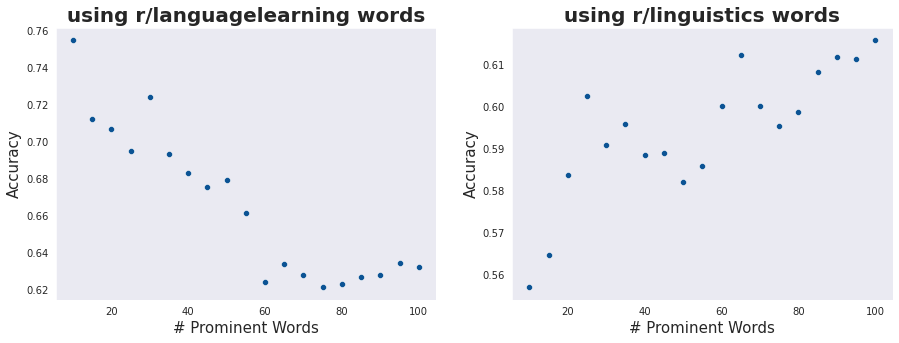

In [5]:
# Performance of the baseline models for various lengths of frequent words list

fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.scatterplot(x = range(10,105,5), y = accuracies['model_1']  , ax = ax[0], alpha = 1, color = myblue)
ax[0].set_title('using r/languagelearning words', fontweight = 'bold')
ax[0].set_xlabel('# Prominent Words')
ax[0].set_ylabel('Accuracy'); 

sns.scatterplot(x = range(10,105,5), y = accuracies['model_2']  , ax = ax[1], alpha = 1, color = myblue)
ax[1].set_title('using r/linguistics words', fontweight = 'bold')
ax[1].set_xlabel('# Prominent Words')
ax[1].set_ylabel('Accuracy'); 

## Comparison of performance of ML classification models

The goal of this section is to improve upon the accuracy of the baseline models using various classification algorithms. The text data was featurized using CountVectorizer and the following classification models were used:

- Random Forest 
- Gradient Boosting
- Voting Classifier

The hyperparameters for the CountVectorizer and the estimators were tuned using a GridSearch. 

For each of the above models, the subreddit posts were classified using three different feature sets.
- model 1 : using the title of the post
- model 2 : using the content (selftext) of the post
- model 3 : using both the title and content of the post

The models using the text from both the title and content of the post (model 3) outperformed the other two models.
The following table summarizes the performance of all of the above models

|                   |                   | Overall Accuracy |           |   | Accuracy of r/languagelearning |           |   |  Accuracy of r/linguistics |           |
|-------------------|-------------------|:----------------:|:---------:|:-:|:------------------------------:|:---------:|:-:|:--------------------------:|:---------:|
|                   |                   |   Training data  | Test Data |   |          Training Data         | Test Data |   |        Training Data       | Test Data |
|   Random Forest   |       Title       |       0.79       |    0.72   |   |              0.69              |    0.62   |   |            0.88            |    0.83   |
|                   |      Content      |       0.84       |    0.8    |   |              0.76              |    0.73   |   |            0.93            |    0.88   |
|                   | Content and title |       0.86       |    0.82   |   |              0.78              |    0.74   |   |            0.94            |    0.9    |
|                   |                   |                  |           |   |                                |           |   |                            |           |
| Gradient Boosting |       Title       |       0.79       |    0.73   |   |              0.68              |    0.61   |   |             0.9            |    0.85   |
|                   |      Content      |       0.86       |    0.81   |   |              0.79              |    0.73   |   |            0.93            |    0.89   |
|                   | Content and title |       0.88       |    0.83   |   |              0.82              |    0.77   |   |            0.95            |    0.89   |
|                   |                   |                  |           |   |                                |           |   |                            |           |
| Voting Classifier |       Title       |        0.8       |    0.74   |   |              0.69              |    0.61   |   |             0.9            |    0.86   |
|                   |      Content      |       0.87       |    0.82   |   |               0.8              |    0.75   |   |            0.94            |    0.88   |
|                   | Content and title |       0.89       |    0.83   |   |              0.82              |    0.77   |   |            0.95            |    0.89   |

In [7]:
#helper function

#shorthand - r/ll is the subreddit languagelearning and r/lg is the subreddit linguistics

def rf_model_evaluation(X, y):
    '''
    For a text column X and target column y, run a grid search with a particular 
    set of parameters for countvectorizing X and fitting a random forest model and return an array with 
    [overall train score, overall test score, 
    r/ll train score, r/ll test score, 
    r/lg train score, r/lg test score,
    best parameters]
    
    TODO: 
    Modify to pass estimator and params as arguments
    Return a dictionary instead of a list
    
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words='english')),
        ('rf', RandomForestClassifier(random_state=42))    
    ])

    pipe_params = {
        'cvec__max_features': [2000,3000,4000,5000],
        'cvec__min_df': [2, 3],
        'cvec__max_df': [0.9],
        'cvec__ngram_range': [(1,1),(1,2),(1,3)],
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [4, 5],
        'rf__max_features': ['sqrt', .5]
    }

    gs = GridSearchCV(
        estimator = pipe,
        param_grid = pipe_params,
        cv = 3,
        n_jobs = -1,
        verbose = 1
    )

    #train-test-split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    #fitting and evaluating the model

    gs.fit(X_train, y_train)
    
    #training accuracy by subreddit
    preds_df = pd.DataFrame({'true': y_train, 'preds' : gs.predict(X_train).tolist() })
    train_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    train_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']
    
    #testing accuracy by subreddit
    preds_df = pd.DataFrame({'true': y_test, 'preds' : gs.predict(X_test).tolist() })
    test_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    test_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']    
    return([
         gs.score(X_train, y_train),
         gs.score(X_test, y_test),
         train_ll, test_ll,
         train_lg, test_lg,
         gs.best_params_
        ])

In [9]:
rf_models_summary = {}
for i,X in enumerate([data['selftext'], data['title'], data['title']+ ' ' + data['selftext']]):
    rf_models_summary[f'model_{i+1}'] = rf_model_evaluation(X, data['subreddit'])
    

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [10]:
rf_models_summary

{'model_1': [0.8486950776346217,
  0.8087215064420218,
  0.7643944407677035,
  0.7321428571428571,
  0.9327176781002638,
  0.8851485148514852,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 3000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 1),
   'rf__max_depth': 5,
   'rf__max_features': 'sqrt',
   'rf__n_estimators': 200}],
 'model_2': [0.7862570201519656,
  0.7284440039643211,
  0.6889477167438782,
  0.623015873015873,
  0.883245382585752,
  0.8336633663366336,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 2000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 1),
   'rf__max_depth': 4,
   'rf__max_features': 'sqrt',
   'rf__n_estimators': 200}],
 'model_3': [0.8658738024446647,
  0.8235877106045589,
  0.786896095301125,
  0.746031746031746,
  0.9445910290237467,
  0.900990099009901,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 3000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 1),
   'rf__max_depth': 5,
   'rf__max_features': 'sqrt',
   'rf__n_estimators': 200}

### Gradient Boosting Classifier

In [8]:
#helper function modified for Gradient Boosting

def gb_model_evaluation(X, y):
    '''
    For a text column X and target column y, run a grid search with a particular 
    set of parameters for countvectorizing X and fitting a gradient boosting model and return an array with 
    [overall train score, overall test score, 
    r/ll train score, r/ll test score, 
    r/lg train score, r/lg test score,
    best parameters]
    
    TODO: 
    Modify to pass estimator and params as arguments
    Return a dictionary instead of a list
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words='english')),
        ('gb', GradientBoostingClassifier(random_state = 42))    
    ])

    pipe_params = {
        'cvec__max_features': [2000,3000,4000,5000],
        'cvec__min_df': [2, 3],
        'cvec__max_df': [0.9],
        'cvec__ngram_range': [(1,2), (1,3)],
        'gb__n_estimators': [20, 50, 100],
        
    }

    gs = GridSearchCV(
        estimator = pipe,
        param_grid = pipe_params,
        cv = 3,
        n_jobs = -1,
        verbose = 1
    )

    #train-test-split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    #fitting and evaluating the model

    gs.fit(X_train, y_train)
    
    #training accuracy by subreddit
    
    preds_df = pd.DataFrame({'true': y_train, 'preds' : gs.predict(X_train).tolist() })
    train_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    train_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']
    
    #testing accuracy by subreddit
    
    preds_df = pd.DataFrame({'true': y_test, 'preds' : gs.predict(X_test).tolist() })
    test_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    test_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']    
    
    return([
         gs.score(X_train, y_train),
         gs.score(X_test, y_test),
         train_ll, test_ll,
         train_lg, test_lg,
         gs.best_params_
        ])

In [9]:
gb_models_summary = {}
for i,X in enumerate([data['selftext'], data['title'], data['title']+ ' ' + data['selftext']]):
    gb_models_summary[f'model_{i+1}'] = gb_model_evaluation(X, data['subreddit'])
    

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [10]:
gb_models_summary

{'model_1': [0.8446713648784697,
  0.817946505608283,
  0.7303476354525524,
  0.6910798122065728,
  0.9417553191489362,
  0.9257781324820431,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 5000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 2),
   'gb__n_estimators': 100}],
 'model_2': [0.7651373507838343,
  0.7493528904227783,
  0.5421233949264015,
  0.5192488262910798,
  0.9545212765957447,
  0.9449321628092577,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 3000,
   'cvec__min_df': 3,
   'cvec__ngram_range': (1, 2),
   'gb__n_estimators': 100}],
 'model_3': [0.8652380267510427,
  0.8390854184641933,
  0.7785781396805512,
  0.7361502347417841,
  0.9388297872340425,
  0.9265762170790104,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 2000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 2),
   'gb__n_estimators': 100}]}

### Voting Classifier

In [11]:
#helper function modified for Voting Classifier

def vc_model_evaluation(X, y):
    '''
    For a text column X and target column y, run a grid search with a particular 
    set of parameters for countvectorizing X and fitting a voting classifier model and return an array with 
    [overall train score, overall test score, 
    r/ll train score, r/ll test score, 
    r/lg train score, r/lg test score,
    best parameters]
    
    TODO: 
    Modify to pass estimator and params as arguments
    Return a dictionary instead of a list
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words='english')),
        ('vote', VotingClassifier([
                                  ('ada', AdaBoostClassifier(random_state=42)),
                                  ('gb', GradientBoostingClassifier(random_state=42)),
                                  ('rf', RandomForestClassifier(random_state=42))
                                ])
        )    
                    ])

    pipe_params = {
        'cvec__max_features': [2000,3000,4000,5000],
        'cvec__min_df': [2, 3],
        'cvec__max_df': [0.9],
        'cvec__ngram_range': [(1,2), (1,3)],
        'vote__ada__base_estimator': [None],
        'vote__ada__n_estimators': [50, 95, 100],
        'vote__gb__n_estimators': [20, 50, 100],
        'vote__rf__max_depth': [5,6],
        'vote__rf__min_samples_split': [3,4]
        
    }

    gs = GridSearchCV(
        estimator = pipe,
        param_grid = pipe_params,
        cv = 3,
        n_jobs = -1,
        verbose = 1
    )

    #train-test-split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    #fitting and evaluating the model

    gs.fit(X_train, y_train)
    
    #training accuracy by subreddit
    
    preds_df = pd.DataFrame({'true': y_train, 'preds' : gs.predict(X_train).tolist() })
    train_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    train_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']
    
    #testing accuracy by subreddit
    
    preds_df = pd.DataFrame({'true': y_test, 'preds' : gs.predict(X_test).tolist() })
    test_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    test_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']    
    
    return([
         gs.score(X_train, y_train),
         gs.score(X_test, y_test),
         train_ll, test_ll,
         train_lg, test_lg,
         gs.best_params_
        ])

In [12]:
vc_models_summary = {}
for i,X in enumerate([data['selftext'], data['title'], data['title']+ ' ' + data['selftext']]):
    vc_models_summary[f'model_{i+1}'] = vc_model_evaluation(X, data['subreddit'])

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


In [13]:
vc_models_summary

{'model_1': [0.8451028333093629,
  0.8235547886108714,
  0.7159411212026308,
  0.6854460093896714,
  0.9547872340425532,
  0.9409417398244214,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 5000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 2),
   'vote__ada__base_estimator': None,
   'vote__ada__n_estimators': 95,
   'vote__gb__n_estimators': 100,
   'vote__rf__max_depth': 6,
   'vote__rf__min_samples_split': 4}],
 'model_2': [0.7624047173881777,
  0.7467644521138913,
  0.529909176323207,
  0.5023474178403756,
  0.9598404255319148,
  0.9545091779728652,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 2000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 3),
   'vote__ada__base_estimator': None,
   'vote__ada__n_estimators': 95,
   'vote__gb__n_estimators': 100,
   'vote__rf__max_depth': 6,
   'vote__rf__min_samples_split': 3}],
 'model_3': [0.8649503811304473,
  0.8408110440034513,
  0.7622925148762919,
  0.7258215962441315,
  0.9521276595744681,
  0.9385474860335196,
  {'cv

In [16]:
#tesing on the same data as the previous model trained on a smaller dataset
testing_data = pd.read_csv('./reddit_data_clean.csv')
test_X = testing_data['title']+ ' ' + testing_data['selftext']
test_y = testing_data['subreddit']

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(test_X, test_y, random_state=42, stratify=test_y)
 

In [20]:
pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words='english')),
        ('vote', VotingClassifier([
                                  ('ada', AdaBoostClassifier(random_state=42)),
                                  ('gb', GradientBoostingClassifier(random_state=42)),
                                  ('rf', RandomForestClassifier(random_state=42))
                                ])
        )    
                    ])

pipe_params = {
'cvec__max_df': [0.9],
'cvec__max_features': [5000],
'cvec__min_df': [2],
'cvec__ngram_range': [(1, 2)],
'vote__ada__base_estimator': [None],
'vote__ada__n_estimators': [95],
'vote__gb__n_estimators': [100],
'vote__rf__max_depth': [6],
'vote__rf__min_samples_split': [3]        
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid = pipe_params,
    cv = 3,
    n_jobs = -1,
    verbose = 1
)
X = data['title']+ ' ' + data['selftext']
y = data['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
gs.fit(X_train, y_train)
gs.score(X_train, y_train)
gs.score(new_X_test,new_y_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('vote',
                                        VotingClassifier(estimators=[('ada',
                                                                      AdaBoostClassifier(random_state=42)),
                                                                     ('gb',
                                                                      GradientBoostingClassifier(random_state=42)),
                                                                     ('rf',
                                                                      RandomForestClassifier(random_state=42))]))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)],
                         'vote__ada__base_estimator': [N

0.8649503811304473

0.8305252725470763

## Further analysis of the best gradient boosting model 

This section is a deeper dive into the gradient boosting model and its performance for various values of the CountVectorization parameters

### Important features

In [42]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=3000, min_df=2, max_df=0.9)
gb = GradientBoostingClassifier(n_estimators = 100, random_state = 42)

X = data['title']+ ' ' + data['selftext']
y = data['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

gb.fit(X_train, y_train)
print('train score: ', gb.score(X_train,y_train))
print('test score: ', gb.score(X_test, y_test))
imp_features = pd.Series(gb.feature_importances_, cv.get_feature_names()).sort_values(ascending=False)
imp_features.head(10)




GradientBoostingClassifier(random_state=42)

train score:  0.8810703666997026
test score:  0.8305252725470763


learning       0.354513
learn          0.131484
linguistics    0.085998
practice       0.021321
app            0.018566
language       0.017102
example        0.013567
level          0.012644
listening      0.010319
anki           0.009613
dtype: float64

### Model performance vs CountVectorizer parameters

Key take-aways:

- Max_features doesn't have a considerable impact on model performance
- 1,2,3 and 5 grams are important in the model. The higher n_grams, don't affect model performance considerably

In [48]:
# accuracy as a function of n when (1,n) n_grams are used:

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('gb', GradientBoostingClassifier(random_state = 42))    
])

pipe_params = {
    'cvec__max_features': [3000],
    'cvec__min_df': [3],
    'cvec__max_df': [0.9],
    'cvec__ngram_range': [(1,i) for i in range(1,25)],
    'gb__n_estimators': [100],
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid = pipe_params,
    cv = 3,
    n_jobs = -1,
    verbose = 1
)

#train-test-split
X = data['title']+ ' ' + data['selftext']
y = data['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

#fitting the model

gs.fit(X_train, y_train)

#model performance vs n_grams used

mean_cv_scores_1n = gs.cv_results_['mean_test_score']

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [3000],
                         'cvec__min_df': [3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4),
                                               (1, 5), (1, 6), (1, 7), (1, 8),
                                               (1, 9), (1, 10), (1, 11),
                                               (1, 12), (1, 13), (1, 14),
                                               (1, 15), (1, 16), (1, 17),
                                               (1, 18), (1, 19), (1, 20),
                                               (1, 21), (1, 22), (1, 23),
                                            

In [49]:
# accuracy as a function of n when (n,n) n_grams are used:

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('gb', GradientBoostingClassifier(random_state = 42))    
])

pipe_params = {
    'cvec__max_features': [3000],
    'cvec__min_df': [3],
    'cvec__max_df': [0.9],
    'cvec__ngram_range': [(i,i) for i in range(1,25)],
    'gb__n_estimators': [100],

}

gs = GridSearchCV(
    estimator = pipe,
    param_grid = pipe_params,
    cv = 3,
    n_jobs = -1,
    verbose = 1
)

#train-test-split


X = data['title']+ ' ' + data['selftext']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

#fitting and evaluating the model

gs.fit(X_train, y_train)

#model performance vs n_grams used

mean_cv_scores_nn = gs.cv_results_['mean_test_score']

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [3000],
                         'cvec__min_df': [3],
                         'cvec__ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4),
                                               (5, 5), (6, 6), (7, 7), (8, 8),
                                               (9, 9), (10, 10), (11, 11),
                                               (12, 12), (13, 13), (14, 14),
                                               (15, 15), (16, 16), (17, 17),
                                               (18, 18), (19, 19), (20, 20),
                                               (21, 21), (22, 22), (23, 23),
                              

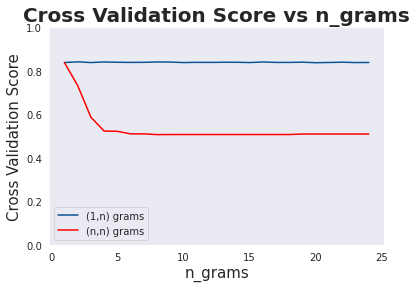

In [52]:
fig, ax = plt.subplots()


sns.lineplot(y = mean_cv_scores_1n, x = [i for i in range(1,25)], 
             ax = ax, alpha = 1, color = myblue, label = '(1,n) grams')
sns.lineplot(y = mean_cv_scores_nn, x = [i for i in range(1,25)], 
             ax = ax, alpha = 1, color = 'red', label = '(n,n) grams')

plt.title('Cross Validation Score vs n_grams', fontweight = 'bold')
plt.xlabel('n_grams')
plt.ylabel('Cross Validation Score')
ax.set(ylim=(0, 1)); 

Fitting 3 folds for each of 91 candidates, totalling 273 fits


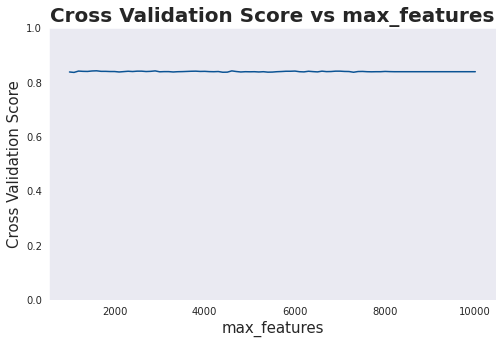

In [47]:
# accuracy as a function of max_features:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('gb', GradientBoostingClassifier(random_state = 42))    
])

pipe_params = {
    'cvec__max_features': [i for i in range(1000,10100,100)],
    'cvec__min_df': [3],
    'cvec__max_df': [0.9],
    'cvec__ngram_range': [(1,3)],
    'gb__n_estimators': [100],

}

gs = GridSearchCV(
    estimator = pipe,
    param_grid = pipe_params,
    cv = 3,
    n_jobs = -1,
    verbose = 1
)

#train-test-split

X = data['title']+ ' ' + data['selftext']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

#fitting the model

gs.fit(X_train, y_train)

#model performance vs max_features used

fig, ax = plt.subplots(figsize = (8,5))
sns.lineplot(y = gs.cv_results_['mean_test_score'], x = [i for i in range(1000,10100,100)], ax = ax, alpha = 1, color = myblue)
plt.title('Cross Validation Score vs max_features', fontweight = 'bold')
plt.xlabel('max_features')
plt.ylabel('Cross Validation Score')
ax.set(ylim=(0, 1)); 

### Some misclassified posts

Just looking at a few for fun - to judge if I could have classified them correctly :)

In [1]:
preds_df = pd.DataFrame({'true_values': y_test, 'preds' : gs.predict(X_test).tolist(), 'text': X_test })
 
misclassified = preds_df[preds_df['true_values'] != preds_df['preds']].reset_index(drop=True)
misclassified.head()
for i in range(0,10):
    misclassified.iloc[i,:]
    misclassified.iloc[i,:]['text']


NameError: name 'pd' is not defined

## Conclusions and TODO

**Conclusions**

- The best performing model (a voting classifier) in the analysis led to a lift of about 9% in accuracy (from 74% to 83%) from the baseline model
- All the classification algorithms had a better accuracy in r/linguistics compared to r/languagelearning
- Using the text from both the title and content of the post resulted in better performance of all the models

**TODO**

- Include numerical features - length of post, character count, number of comments etc in the analysis
- Preprocess the text - stemming, lemmatizing, augmenting the stopwords
- Try other kinds of vectorization of the text (TfidfVectorizer)
- Analyze larger samples of data
- More hyperparameter tuning
- Use other classification algorithms 


